In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
import geopandas
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import math
from scipy.stats import norm

/var/folders/y3/ph_dk0xn09n503mvdjfq9r1h0000gn/T/ipykernel_35465/3369938989.py:1: DtypeWarning: Columns (10,12,13,14,15,16,17,18,19,20,27,28,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv("National_Interagency_Fire_Occurrence_Sixth_Edition_1992-2020_(Feature_Layer).csv")


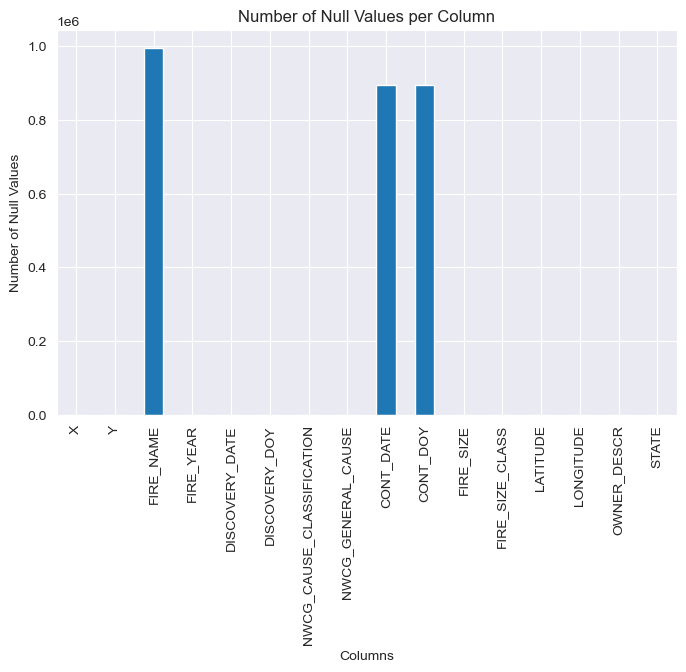

<class 'pandas.core.frame.DataFrame'>
Index: 3490 entries, 16 to 2303564
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   X                          3490 non-null   float64            
 1   Y                          3490 non-null   float64            
 2   FIRE_NAME                  3475 non-null   object             
 3   FIRE_YEAR                  3490 non-null   int32              
 4   DISCOVERY_DATE             3490 non-null   datetime64[ns, UTC]
 5   DISCOVERY_DOY              3490 non-null   int64              
 6   NWCG_CAUSE_CLASSIFICATION  3490 non-null   object             
 7   NWCG_GENERAL_CAUSE         3490 non-null   object             
 8   CONT_DATE                  3490 non-null   datetime64[ns, UTC]
 9   CONT_DOY                   3490 non-null   float64            
 10  FIRE_SIZE                  3490 non-null   float64            
 11  FIRE_

In [17]:
file = pd.read_csv("National_Interagency_Fire_Occurrence_Sixth_Edition_1992-2020_(Feature_Layer).csv")
dataframe = pd.DataFrame(file)
#print(dataframe.info())
#print(dataframe.head())
new_data = pd.DataFrame(file)
new_data.drop(["LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID", "FIRE_CODE", "ICS_209_PLUS_INCIDENT_JOIN_ID", "ICS_209_PLUS_COMPLEX_JOIN_ID", "MTBS_ID", "MTBS_FIRE_NAME", "COMPLEX_NAME", "DISCOVERY_TIME", "CONT_TIME", "NWCG_CAUSE_AGE_CATEGORY", "FIPS_CODE", "FIPS_NAME", "OBJECTID", "FOD_ID", "FPA_ID", "SOURCE_SYSTEM_TYPE", "SOURCE_SYSTEM", "NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_ID", "NWCG_REPORTING_UNIT_NAME", "SOURCE_REPORTING_UNIT", "SOURCE_REPORTING_UNIT_NAME", "COUNTY"], axis=1, inplace=True)
#new_data.dropna(subset=["FIRE_NAME"], inplace=True)
null_counts = new_data.isnull().sum()

    # Create a bar chart
plt.figure(figsize=(8, 5))
null_counts.plot(kind='bar')
plt.title('Number of Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.show()
new_data.dropna(subset=["CONT_DATE"], inplace=True)
#sns.displot(new_data["NWCG_CAUSE_CLASSIFICATION"])
#plt.show()
new_data.drop(new_data[new_data['NWCG_CAUSE_CLASSIFICATION'] == 'Missing data/not specified/undetermined' ].index, inplace=True)
new_data.drop(new_data[new_data["NWCG_GENERAL_CAUSE"] == 'Missing data/not specified/undetermined' ].index, inplace=True)
#sns.displot(new_data["NWCG_CAUSE_CLASSIFICATION"])
#plt.show()
#new_data.drop(new_data[new_data["FIRE_YEAR"] == 2004].index, inplace=True)

new_data["DISCOVERY_DATE"] = pd.to_datetime(new_data["DISCOVERY_DATE"], errors='coerce',utc=True)
new_data["CONT_DATE"] = pd.to_datetime(new_data["CONT_DATE"], errors='coerce',utc=True)
new_data["FIRE_YEAR"] = pd.to_datetime(new_data["FIRE_YEAR"], format="%Y")
new_data["FIRE_YEAR"] = new_data["FIRE_YEAR"].dt.year
firedf = new_data[(new_data["FIRE_SIZE"] > 5000) ]
#sns.displot(firedf["NWCG_CAUSE_CLASSIFICATION"])
#plt.show()
print(firedf.info())
#firedf = new_data.copy()
#firedf.head()
#df_corr = firedf.select_dtypes(include="number").corr()


#plt.figure(figsize=(20,15))
#sns.heatmap(data=df_corr, annot=True)
#sns.pairplot(firedf)

# States and Regions


### Set up Regions

In [3]:
#Location Splits
states_dict = {
    "West": ["WA", "OR", "CA", "AZ", "UT", "NV", "CO", "WY", "MT", "ID", "NM", "AK"],
    "Midwest": ["ND", "SD", "NE", "KS", "MN", "MI"],
    "South": ["TX", "OK", "AK", "NC", "FL", "GA" ]
}
def region(state):
    for region, states in states_dict.items():
        if state in states:
            return region
    

### Crosstab: Regions Proportions

/var/folders/y3/ph_dk0xn09n503mvdjfq9r1h0000gn/T/ipykernel_35465/47263453.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fires_per_year = statesdf.groupby(["FIRE_YEAR", "Region"]).size().unstack()


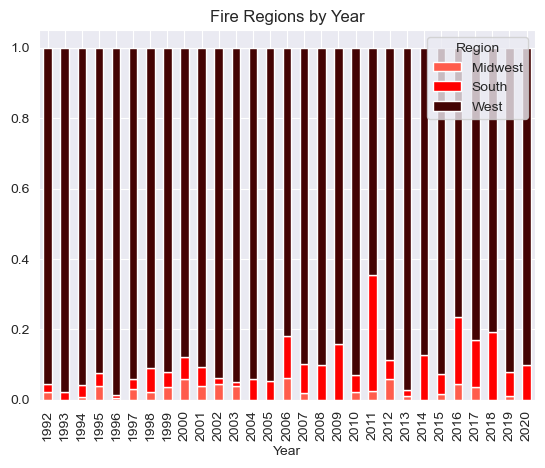

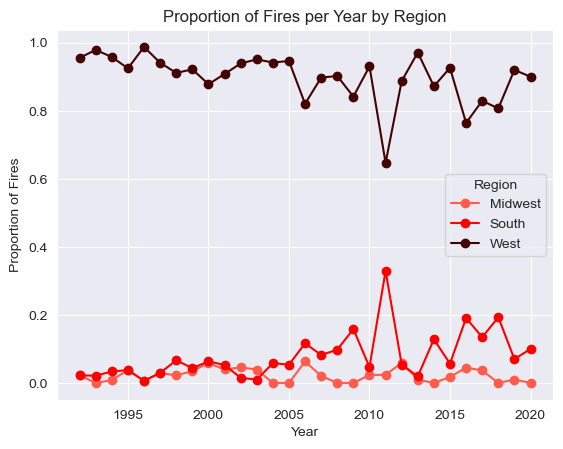

In [21]:
statesdf = firedf.copy()
statesdf["Region"] = statesdf["STATE"].apply(region)
statesdf["Region"] = statesdf["Region"].astype("category")
#df_filtered = statesdf[statesdf['FIRE_YEAR'].isin([1992, 2004, 2020])]
df_filtered = statesdf
sns.set_style("darkgrid")
colors = ["#ff5c4c","#FF0000", "#440303"]
pd.crosstab(df_filtered["FIRE_YEAR"], df_filtered["Region"], normalize='index').plot(kind="bar", stacked=True, color=colors)
plt.title("Fire Regions by Year")
plt.xlabel("Year")
fires_per_year = statesdf.groupby(["FIRE_YEAR", "Region"]).size().unstack()
fires_proportion = fires_per_year.div(fires_per_year.sum(axis=1), axis=0)
fires_proportion.plot(kind="line", marker="o", color=colors)

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Proportion of Fires")
plt.title("Proportion of Fires per Year by Region")
plt.legend(title="Region")

### Map: Fire Count by State

(Used AI)

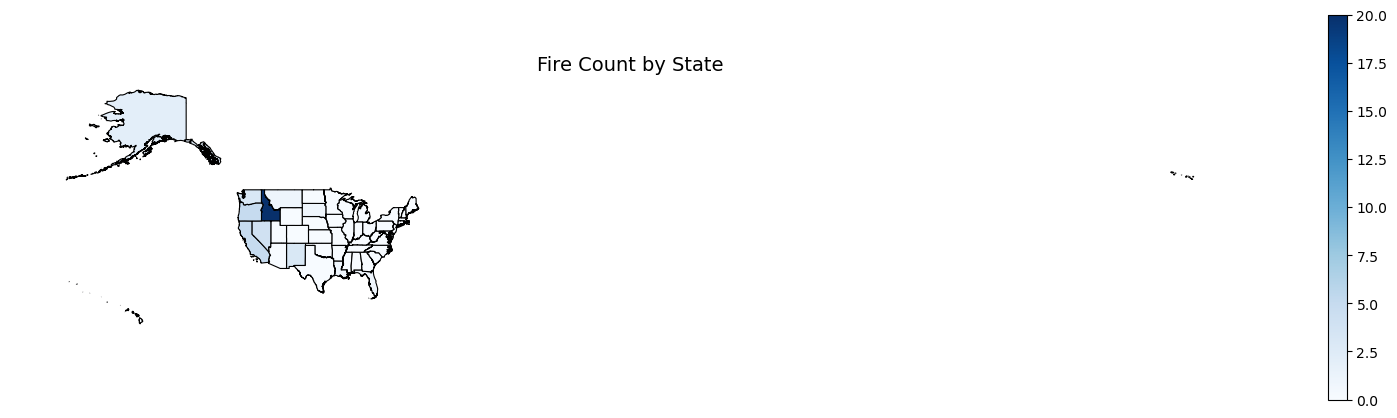

In [5]:
states_map = geopandas.read_file("/Users/sbg/Desktop/wildfires/cb_2018_us_state_500k")
state_counts = firedf.copy()
us_states_abbr = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
    "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA",
    "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
state_counts = state_counts[state_counts["FIRE_YEAR"] == 1992]
filtered_states = states_map[states_map["STUSPS"].isin(us_states_abbr)]
state_counts = state_counts.groupby('STATE').size().reset_index(name='Count')
merged = filtered_states.merge(state_counts, left_on="STUSPS", right_on="STATE", how="left")
merged["Count"] = merged["Count"].fillna(0)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
merged.plot(column="Count", cmap="Blues", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

ax.set_title("Fire Count by State", fontsize=14)
ax.axis("off")
plt.show()


### Bar Plot: Count of Fires per state

# Causes

### Pie Chart: Causes in 1992, 2004, 2020

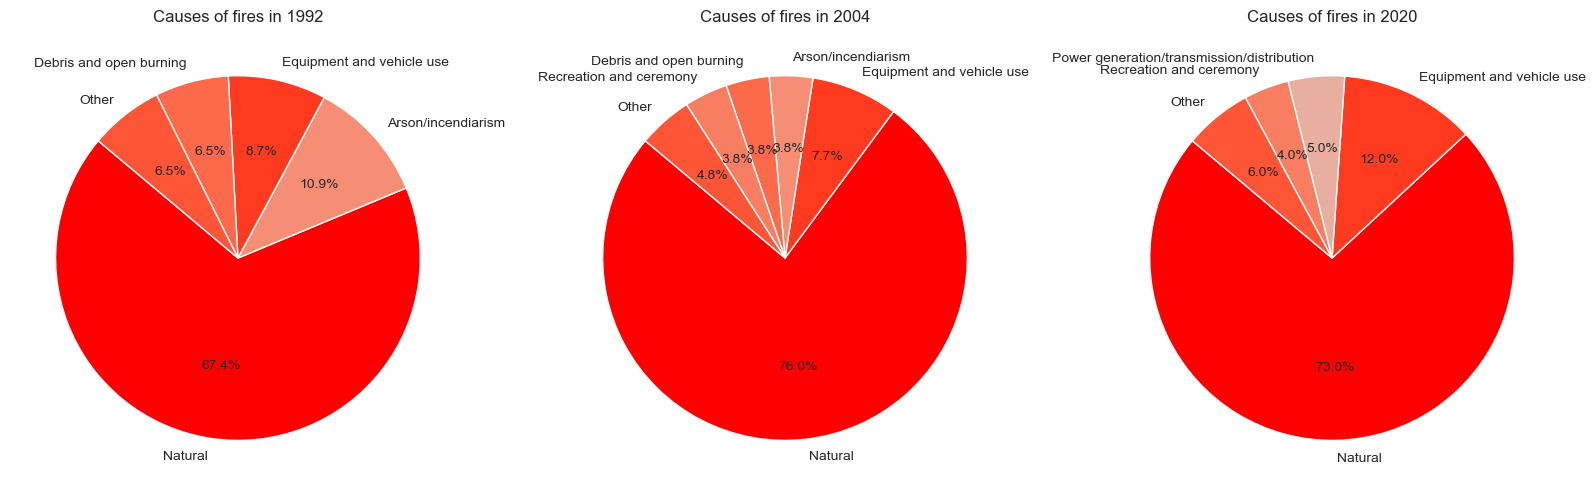

In [18]:
#states_by_year = firedf.groupby("FIRE_YEAR")["NWCG_GENERAL_CAUSE"].value_counts().reset_index()
#sns.barplot(states_by_year["Region"])
target_years = [1992,2004,2020]
ccolors = {
    "Natural": "#ff0000",
    "Other" : "#fe5536",
    "Equipment and vehicle use": "#ff3a1f",
    "Debris and open burning": "#fc6a4b",
    "Recreation and ceremony" : "#f97d60",
    "Arson/incendiarism":  "#f58e74",
    "Smoking":  "#f09e8a",
    "Power generation/transmission/distribution" : "#e8ae9f"
}
colorssns = sns.color_palette()
df_filtered = firedf[firedf['FIRE_YEAR'].isin([1992, 2004, 2020])]
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for i, year in enumerate(target_years):
    cause_counts = df_filtered[df_filtered["FIRE_YEAR"] == year]["NWCG_GENERAL_CAUSE"].value_counts()
    dic= cause_counts.to_dict()
    newdic={}
    for key, group in itertools.groupby(dic, lambda k: 'Other' if (dic[k]<2.1) else k):
         newdic[key] = sum([dic[k] for k in list(group)])   

    labels = newdic.keys()
    sizes = newdic.values()
    colors = [ccolors[cause] for cause in labels]
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[i].set_title(f"Causes of fires in {year}")




### Machine Learning Model to predict whether a fire is human or natural

In [7]:

horn = firedf.copy()
horn.drop(["DISCOVERY_DATE", "CONT_DATE", "FIRE_SIZE_CLASS", "OWNER_DESCR", "X", "Y", "FIRE_YEAR", "FIRE_NAME", "NWCG_GENERAL_CAUSE"], axis=1, inplace=True)
le = LabelEncoder()
horn["Cause"]  = le.fit_transform(horn["NWCG_CAUSE_CLASSIFICATION"] )
horn.drop("NWCG_CAUSE_CLASSIFICATION", axis=1, inplace=True)
horn = pd.get_dummies(horn)
X = horn.drop('Cause', axis=1)
y = horn["Cause"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
cause_class = RandomForestClassifier(n_estimators=200)
cause_class.fit(X_train, y_train)
print(cause_class.score(X_test,y_test))
#horn["LOG_SIZE"] = horn["FIRE_SIZE"].apply(lambda x: math.log(x))
#sns.kdeplot(horn, x=horn["LOG_SIZE"], hue="Cause")
#plt.show()
#sns.violinplot(x=horn["Cause"], y=horn["LOG_SIZE"])
#plt.show()



0.8252148997134671


# Fire Counts and Season

### Scatterplot: Fire Counts per year (Lowess Line)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.141
Date:                Mon, 24 Mar 2025   Prob (F-statistic):             0.0876
Time:                        14:45:56   Log-Likelihood:                -155.73
No. Observations:                  29   AIC:                             315.5
Df Residuals:                      27   BIC:                             318.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4131.7823   2399.325     -1.722      0.0

Text(0.5, 1.0, 'The number of fires from 1992-2020 over 5,000 Acres')

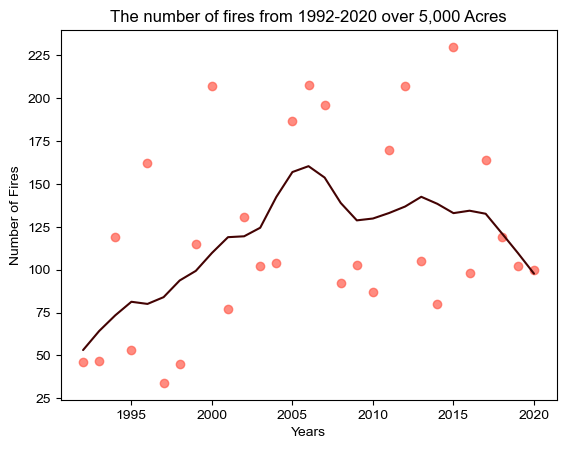

In [8]:
#Fires per year
#the_split = firedf.groupby(by="FIRE_YEAR")["NWCG_CAUSE_CLASSIFICATION"].value_counts()
#fire_counts = firedf[firedf["NWCG_CAUSE_CLASSIFICATION"] == "Natural"]
fire_counts = firedf['FIRE_YEAR'].value_counts().sort_index()
x = fire_counts.index
y = fire_counts.values
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#plt.scatter(x, y, alpha=0.7, color="#b17e96")
plt.scatter(x, y, alpha=0.7, color="#ff5c4c")
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
print(model.summary())
#sns.lineplot(x=x,y=model.fittedvalues, color="#2a2035")
#sns.lineplot(x=x,y=model.fittedvalues)
sns.set_style("darkgrid")
lowess = sm.nonparametric.lowess
smoothed_data = lowess(y, x, frac=0.3)
plt.plot(smoothed_data[:, 0], smoothed_data[:, 1],  label='LOWESS Smoothing', color="#440303")
slope = np.polyfit(x,y,1)[0]
print(slope)
plt.xlabel("Years")
plt.ylabel("Number of Fires")
plt.title("The number of fires from 1992-2020 over 5,000 Acres")



### Prediction Model (Linear Regression)

### Boxplot: Length of Season of Natural Wildfires (1992, 2004, 2020)

(Used AI)

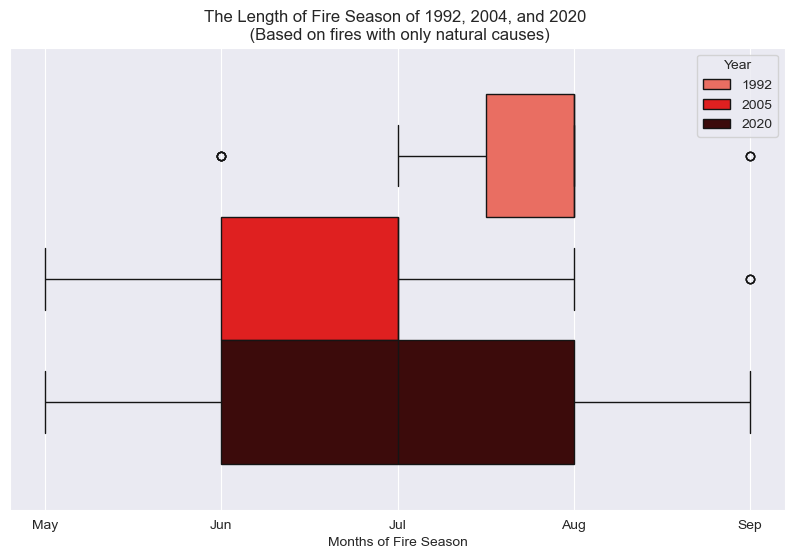

In [9]:
#USED AI TO GET THE X-TICKS WORKING
#Natural fire season
months = firedf.copy()
months = months[months["NWCG_CAUSE_CLASSIFICATION"] == "Natural"]
months.loc[:, 'Month'] = months['DISCOVERY_DATE'].dt.month
df_years  =months[months["FIRE_YEAR"].isin([1992,2005,2020])].copy()
month_order = {5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}
colors = ["#ff5c4c","#FF0000", "#440303"]
df_years['Month'] = df_years['Month'].map(month_order) 
df_years['Month'] = pd.Categorical(df_years['Month'], categories=month_order.values(), ordered=True)
plt.figure(figsize=(10, 6))
sns.boxplot(df_years, x='Month', hue='FIRE_YEAR', palette=colors)
plt.xlabel("Months of Fire Season")
plt.title("The Length of Fire Season of 1992, 2004, and 2020 \n (Based on fires with only natural causes)")
plt.legend(title="Year")
plt.show()


### Scatter plot + Model: Mean Fire Size per year

                            OLS Regression Results                            
Dep. Variable:              FIRE_SIZE   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     7.083
Date:                Mon, 24 Mar 2025   Prob (F-statistic):             0.0134
Time:                        14:46:50   Log-Likelihood:                -275.31
No. Observations:                  27   AIC:                             554.6
Df Residuals:                      25   BIC:                             557.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.907e+05   3.07e+05     -2.575      0.0

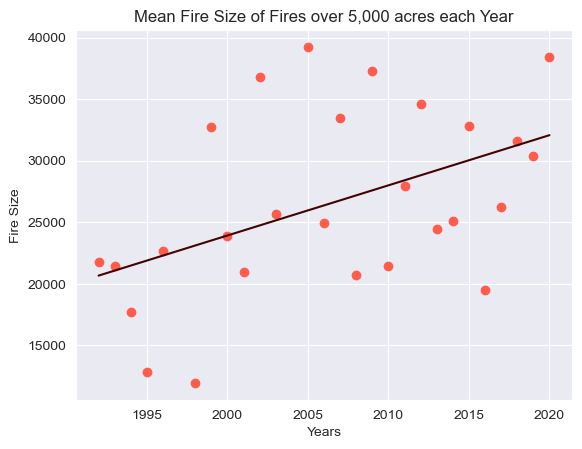

In [19]:
mean_fire_per_year = firedf.groupby('FIRE_YEAR')['FIRE_SIZE'].mean().reset_index()
mean_fire_per_year = mean_fire_per_year[mean_fire_per_year["FIRE_YEAR"] != 2004]
mean_fire_per_year = mean_fire_per_year[mean_fire_per_year["FIRE_YEAR"] != 1997]
x = mean_fire_per_year[["FIRE_YEAR"]]
y = np.log(mean_fire_per_year["FIRE_SIZE"])
y = mean_fire_per_year["FIRE_SIZE"]
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.scatter(x,y, color="#ff5c4c")
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()
sns.lineplot(x=mean_fire_per_year["FIRE_YEAR"], y=model.fittedvalues, color="#440303")
plt.xlabel("Years")
plt.ylabel("Fire Size")
plt.title("Mean Fire Size of Fires over 5,000 acres each Year")
sns.set_style("darkgrid")
print(model.summary())


# Putting Fires Out

### How long it takes to put fires out depending on fire size

                            OLS Regression Results                            
Dep. Variable:        time_difference   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     427.8
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           9.56e-90
Time:                        14:45:56   Log-Likelihood:                -17522.
No. Observations:                3490   AIC:                         3.505e+04
Df Residuals:                    3488   BIC:                         3.506e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -95.8843      6.332    -15.142      0.0

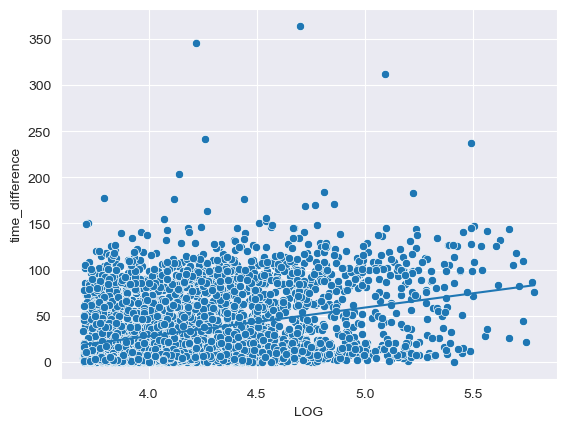

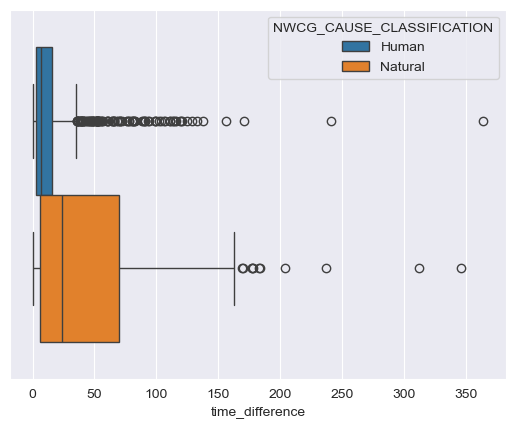

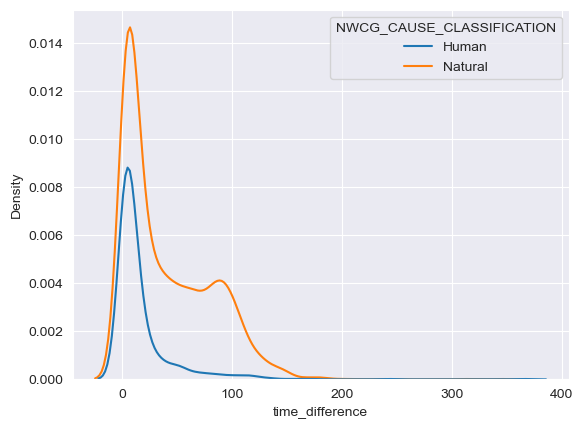

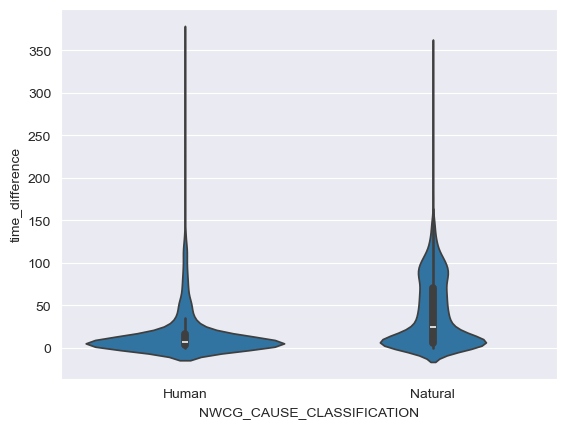

In [11]:
#Limited at 250
time_change = firedf.copy()
time_change["time_difference"]= (time_change["CONT_DATE"] -  time_change["DISCOVERY_DATE"]).dt.days
time_change["LOG"] = time_change["FIRE_SIZE"].apply(lambda x: math.log10(x))
#time_change = time_change[time_change["time_difference"] < 250]
regr = LinearRegression()
model = smf.ols('time_difference ~ LOG', data=time_change).fit()
print(model.summary())
sns.scatterplot(data=time_change, x="LOG", y="time_difference")
sns.lineplot(x=time_change["LOG"], y=model.fittedvalues)
plt.show()
sns.boxplot(time_change, x=(time_change["time_difference"]), hue="NWCG_CAUSE_CLASSIFICATION")
plt.show()
#mean_time = time_change.groupby("FIRE_YEAR")["time_difference"].mean().reset_index()
#plt.scatter(mean_time.index, )
sns.kdeplot(time_change, x=time_change["time_difference"], hue="NWCG_CAUSE_CLASSIFICATION")
plt.show()
sns.violinplot(x="NWCG_CAUSE_CLASSIFICATION", y=time_change["time_difference"], data=time_change)
plt.show()


    

### How long it took to put out fires each year?

                            OLS Regression Results                            
Dep. Variable:        time_difference   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     13.49
Date:                Mon, 24 Mar 2025   Prob (F-statistic):            0.00109
Time:                        15:24:46   Log-Likelihood:                -103.51
No. Observations:                  28   AIC:                             211.0
Df Residuals:                      26   BIC:                             213.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1624.8199    451.276     -3.600      0.0

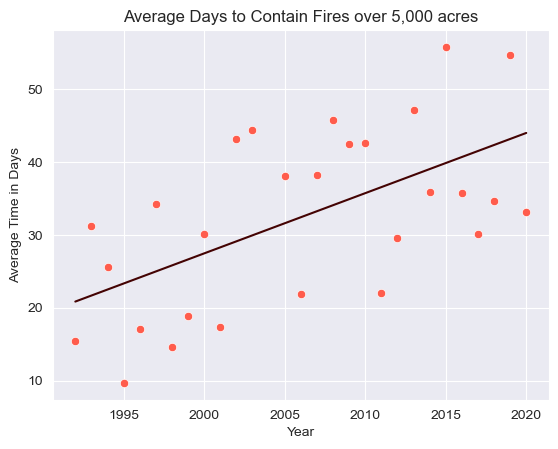

<Axes: xlabel='FIRE_YEAR', ylabel='time_difference'>

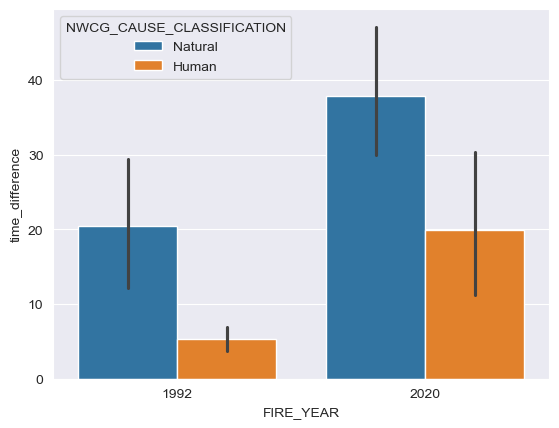

In [20]:
time_changes = firedf.copy()
time_changes["time_difference"]= (time_changes["CONT_DATE"] -  time_changes["DISCOVERY_DATE"]).dt.days
time_changes = time_changes[time_changes["FIRE_YEAR"] != 2004]

time_change = time_changes.groupby('FIRE_YEAR')["time_difference"].mean().reset_index()
sns.scatterplot(time_change, y = "time_difference",  x= "FIRE_YEAR", color="#ff5c4c")
X = time_change["FIRE_YEAR"]
y = time_change["time_difference"]
model = smf.ols('time_difference ~ FIRE_YEAR', data=time_change).fit()
print(model.summary())
sns.lineplot(x=time_change["FIRE_YEAR"], y=model.fittedvalues, color="#440303")
plt.title("Average Days to Contain Fires over 5,000 acres")
plt.xlabel("Year")
plt.ylabel("Average Time in Days")
plt.show()
time_changes = time_changes[time_changes["FIRE_YEAR"].isin([1992, 2004, 2020])]
sns.barplot(time_changes, x="FIRE_YEAR", y="time_difference", hue="NWCG_CAUSE_CLASSIFICATION")

    

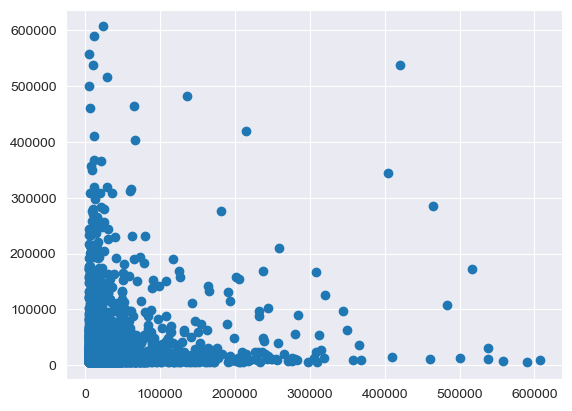

In [13]:
X = firedf["FIRE_SIZE"].shift(1)
y = firedf["FIRE_SIZE"]
train_size = int(len(X) * .8)
train_X, test_X = X[1:train_size], X[train_size:]
train_y, test_y = y[1:train_size], y[train_size:]
model = sm.OLS(train_y, train_X)
result = model.fit()
plt.scatter(X,y)

/var/folders/y3/ph_dk0xn09n503mvdjfq9r1h0000gn/T/ipykernel_35465/1226334445.py:24: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'date': pd.date_range(start='1992-01-01', periods=29, freq='Y'),


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.293
Date:                Mon, 24 Mar 2025   Prob (F-statistic):              0.142
Time:                        14:45:58   Log-Likelihood:                -11.011
No. Observations:                  29   AIC:                             26.02
Df Residuals:                      27   BIC:                             28.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0325      0.133     75.606      0.000       9.760      10.305
time_index  3.373e-05   2.23e-05      1.514      0.142    -1.2e-05    7.94e-05
==============================================================================
Omnibus:                        5.007   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.292
Skew:                           0.646   Prob(JB):                        0.193
Kurtosis:                       4.028   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

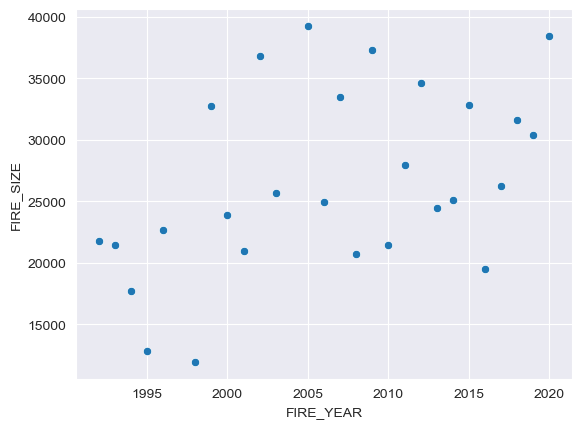

In [14]:
mean_fire_per_year = firedf.groupby('FIRE_YEAR')['FIRE_SIZE'].mean().reset_index()
Q1 = mean_fire_per_year['FIRE_SIZE'].quantile(0.25)
Q3 = mean_fire_per_year['FIRE_SIZE'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = mean_fire_per_year[(mean_fire_per_year['FIRE_SIZE'] >= lower_bound) & (mean_fire_per_year['FIRE_SIZE'] <= upper_bound)]
regr = LinearRegression()
X = df_no_outliers["FIRE_YEAR"]
y = df_no_outliers["FIRE_SIZE"].apply(lambda x:np.log(x))
X = X.values.reshape(-1,1)
regr.fit(X,y)
regr.score(X,y)
sns.scatterplot(x=df_no_outliers["FIRE_YEAR"], y=df_no_outliers["FIRE_SIZE"])
#plt.scatter(df_no_outliers.index, df_no_outliers.values)
#model = sm.OLS("FIRE_SIZE ~ FIRE_YEAR", data=mean_fire_per_year)
data = {
    'date': pd.date_range(start='1992-01-01', periods=29, freq='Y'),
    'count': mean_fire_per_year["FIRE_SIZE"].apply(lambda x:np.log(x))
}
df = pd.DataFrame(data)
#print(new_fires)
#df = pd.DataFrame(new_fires)
df['time_index'] = (df["date"]- df["date"].min()).dt.days
X = sm.add_constant(df['time_index']) 
y = df['count']
model = sm.OLS(y, X).fit()
model.summary()